In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [259]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
import numba
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import compute_sample_weight
from sklearn.feature_selection import RFE
from IPython.display import display
from functools import reduce

In [206]:
@numba.jit('float64[:](float64[:, :])')
def gini(X):
    '''
    Parameters:
        X: array-like, shape (N, M)
    
    Returns:
        G: array-like, shape (N,)
            Gini coefficients across columns (axis=1)
    '''
    N, M = X.shape
    G = np.zeros(N, dtype=np.float64)
    scale = 0.5/(M*M)
    for n in range(N):
        mean = 0
        for m in range(M):
            mean += X[n, m]
        mean /= M
        dev = 0
        for i in range(M):
            for j in range(M):
                dev += np.abs(X[n, i] - X[n, j])
        G[n] = scale*dev/mean
    return G

def cv(X):
    return X.std(axis=1)/X.mean(axis=1)

def fano(X):
    return X.var(axis=1)/X.mean(axis=1)

In [261]:
datasets = ['PNAS2018_Plasma', 'transcripts_exrna']

In [270]:
sample_classes = []
m = []
for dataset in datasets:
    sample_classes.append(pd.read_table('metadata/sample_classes.{}.txt'.format(dataset),
                                   index_col=0, header=None).iloc[:, 0])
    m.append(pd.read_table('output/count_matrix/{}.txt'.format(dataset),
                      index_col=0))
sample_classes = pd.concat(sample_classes)
sample_ids = np.concatenate([a.columns.values for a in m])
features = reduce(np.union1d, [a.index.values for a in m])
n_samples = sum([a.shape[1] for a in m])
m_union = pd.DataFrame(np.zeros((len(features), n_samples)), index=features, columns=sample_ids)
for a in m:
    m_union.loc[a.index.values, a.columns.values] = a.values
m = m_union

if dataset in ('piranha_peaks', 'piranha_peaks_iterative'):
    m = m.loc[:, m.columns.isin(sample_classes.index)]
print('number of samples: {}, number of features, {}'.format(m.shape[1], m.shape[0]))
print('Original matrix:')
display(m.head())

print('CPM matrix:')
read_depth = m.sum(axis=0)
cpm = m*(1.0e6)/read_depth
display(cpm.head())

nonzero_fraction = (~np.isclose(cpm, 0)).mean(axis=1)
cpm_filtered = cpm.loc[nonzero_fraction > 0.10, :]
print('number of features after filtering by nonzero fraction: {}'.format(cpm_filtered.shape[0]))
display(cpm_filtered.head())

number of samples: 277, number of features, 147159
Original matrix:


,SRR7101178,SRR7101180,SRR7101181,SRR7101184,SRR7101187,SRR7101189,SRR7101190,SRR7101191,SRR7101193,SRR7101194,...,Normal-3,Normal-4,Normal-5,Normal-6,Normal-7,Normal-8,SH325716-B,SH327409-B,SH327412-B,SH327428-B
10904|10904|93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,4.0,0.0,4.0,0.0,9.0,4.0,1.0,0.0,1.0
12954|12954|94,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,...,14.0,20.0,32.0,23.0,17.0,92.0,29.0,19.0,10.0,25.0
12956|12956|72,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,...,47.0,54.0,34.0,56.0,62.0,221.0,164.0,65.0,131.0,64.0
12958|12958|82,4.0,9.0,15.0,0.0,25.0,7.0,16.0,29.0,1.0,8.0,...,18.0,29.0,15.0,71.0,9.0,71.0,94.0,19.0,22.0,20.0
12960|12960|73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


CPM matrix:


,SRR7101178,SRR7101180,SRR7101181,SRR7101184,SRR7101187,SRR7101189,SRR7101190,SRR7101191,SRR7101193,SRR7101194,...,Normal-3,Normal-4,Normal-5,Normal-6,Normal-7,Normal-8,SH325716-B,SH327409-B,SH327412-B,SH327428-B
10904|10904|93,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.025062,0.089101,0.000000,0.078897,0.000000,0.196204,0.093667,0.025119,0.000000,0.023426
12954|12954|94,0.000000,0.000000,1.092026,0.0,0.705239,2.443805,0.000000,0.000000,0.000000,2.76758,...,0.350870,0.445505,0.843664,0.453658,0.378341,2.005640,0.679084,0.477264,0.233772,0.585639
12956|12956|72,0.000000,1.951856,1.092026,0.0,0.705239,0.000000,0.000000,0.000000,0.000000,4.15137,...,1.177919,1.202863,0.896393,1.104560,1.379833,4.817896,3.840335,1.632747,3.062418,1.499235
12958|12958|82,9.461902,17.566700,8.190192,0.0,17.630975,8.553316,24.004741,15.562448,1.230912,11.07032,...,0.451118,0.645982,0.395467,1.400424,0.200298,1.547831,2.201168,0.477264,0.514299,0.468511
12960|12960|73,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.019724,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


number of features after filtering by nonzero fraction: 15917


,SRR7101178,SRR7101180,SRR7101181,SRR7101184,SRR7101187,SRR7101189,SRR7101190,SRR7101191,SRR7101193,SRR7101194,...,Normal-3,Normal-4,Normal-5,Normal-6,Normal-7,Normal-8,SH325716-B,SH327409-B,SH327412-B,SH327428-B
10904|10904|93,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.025062,0.089101,0.000000,0.078897,0.000000,0.196204,0.093667,0.025119,0.000000,0.023426
12954|12954|94,0.000000,0.000000,1.092026,0.000000,0.705239,2.443805,0.000000,0.000000,0.000000,2.76758,...,0.350870,0.445505,0.843664,0.453658,0.378341,2.005640,0.679084,0.477264,0.233772,0.585639
12956|12956|72,0.000000,1.951856,1.092026,0.000000,0.705239,0.000000,0.000000,0.000000,0.000000,4.15137,...,1.177919,1.202863,0.896393,1.104560,1.379833,4.817896,3.840335,1.632747,3.062418,1.499235
12958|12958|82,9.461902,17.566700,8.190192,0.000000,17.630975,8.553316,24.004741,15.562448,1.230912,11.07032,...,0.451118,0.645982,0.395467,1.400424,0.200298,1.547831,2.201168,0.477264,0.514299,0.468511
12962|12962|72,0.000000,3.903711,1.092026,1.716665,3.526195,1.221902,0.000000,1.073272,0.000000,1.38379,...,1.052609,1.247414,1.080944,0.848144,1.468854,2.725054,1.732834,0.552622,0.794826,0.679341


In [271]:
gini_coefs = gini(cpm_filtered.values)
cv_coefs = cv(cpm_filtered.values)
fano_coefs = fano(cpm_filtered.values)

In [272]:
cpm_filtered.index[np.log2(cpm_filtered + 0.01).mean(axis=1) > 5]

Index(['22641|22641|72', '28963|28963|72', 'ENST00000362102.3|MIRLET7E-201|79',
       'ENST00000362103.4|MIR375-201|64', 'ENST00000362104.3|MIR30E-201|92',
       'ENST00000362105.2|MIRLET7A2-201|72', 'ENST00000362111.4|MIR29A-201|64',
       'ENST00000362114.1|MIR345-201|98', 'ENST00000362116.3|MIRLET7A3-201|74',
       'ENST00000362117.1|MIR16-2-201|81',
       ...
       'ENST00000624215.1|AL031595.2-201|19071',
       'ENST00000626826.1|HELLPAR-201|205012',
       'ENST00000638356.1|AD000090.1-201|23999', 'T089164|T089164|28419',
       'T222969|T222969|16295', 'piR-hsa-1177|piR-hsa-1177|31',
       'piR-hsa-20266_2|piR-hsa-20266_2|27', 'piR-hsa-20266|piR-hsa-20266|27',
       'piR-hsa-20572_3700|piR-hsa-20572_3700|126517',
       'piR-hsa-27282|piR-hsa-27282|28'],
      dtype='object', length=210)

Text(0,0.5,'CV')

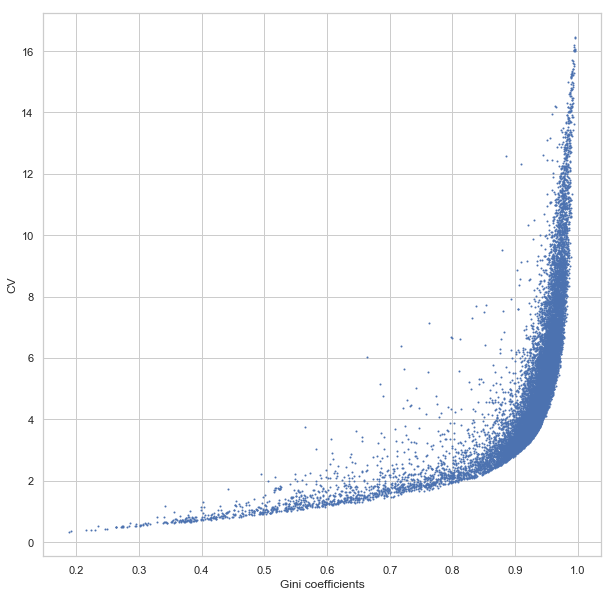

In [273]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(gini_coefs, cv_coefs, s=1)
ax.set_xlabel('Gini coefficients')
ax.set_ylabel('CV')

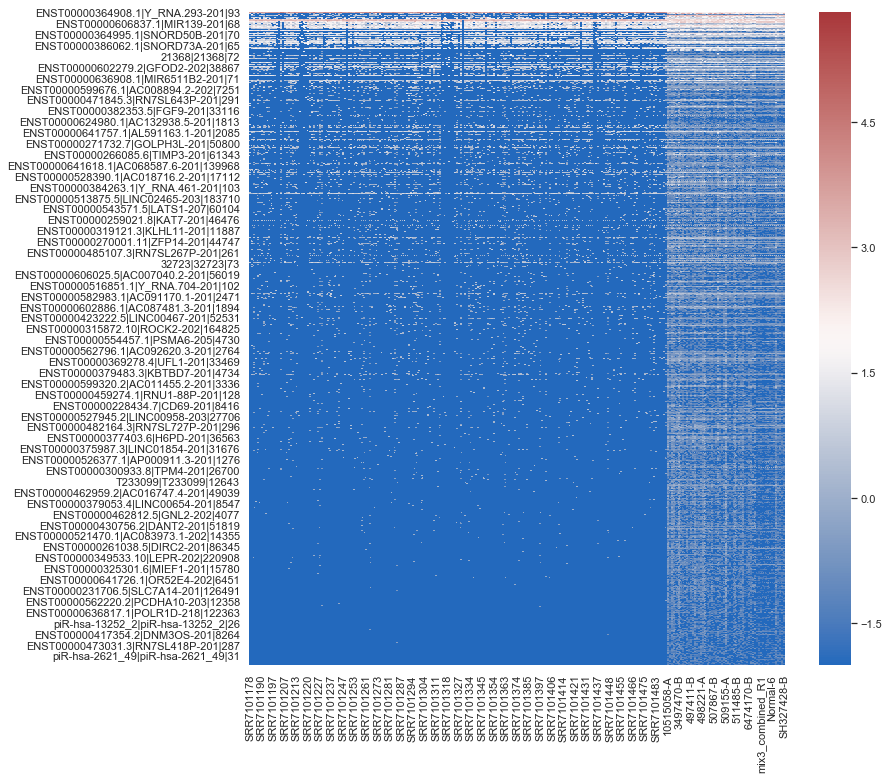

In [274]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(np.log10(cpm_filtered.iloc[np.argsort(-fano_coefs)] + 0.01), ax=ax, cmap='vlag')

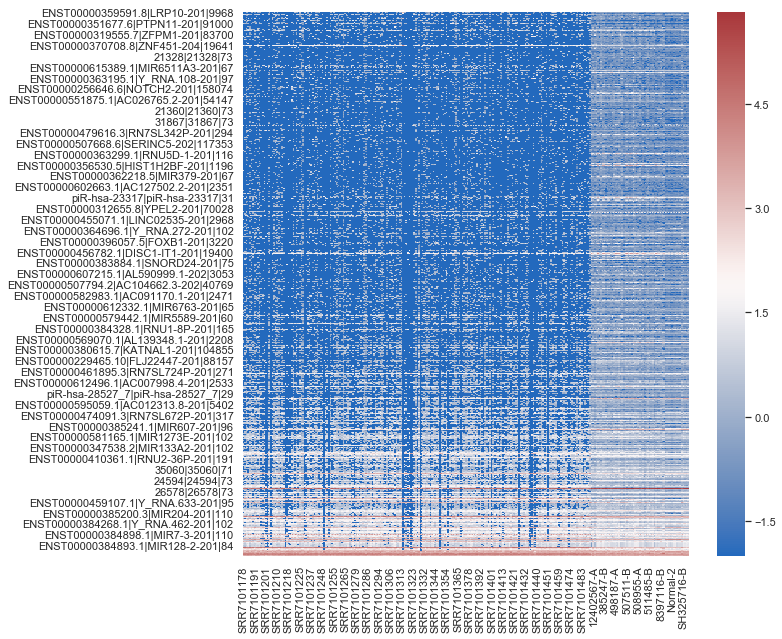

In [268]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(np.log10(cpm_filtered.iloc[np.argsort(-cv_coefs)] + 0.01), ax=ax, cmap='vlag')

unique classes: Healthy, stage_A, stage_B, stage_C, Normal


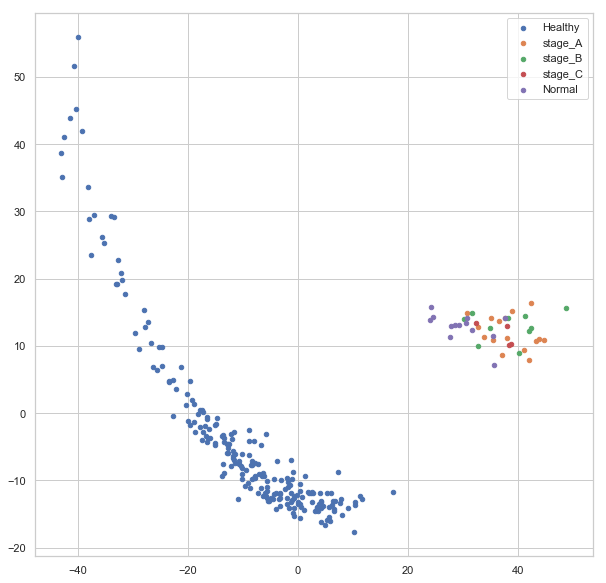

In [269]:
unique_classes = sample_classes.unique()
print('unique classes:', ', '.join(unique_classes))

X = np.log10(cpm_filtered.iloc[np.argsort(fano_coefs)[-2000:]] + 0.01).T
X = StandardScaler().fit_transform(X)
pca = PCA(2).fit_transform(X)
fig, ax = plt.subplots(figsize=(10, 10))
for unique_class in unique_classes:
    ax.scatter(pca[sample_classes[cpm.columns] == unique_class, 0],
               pca[sample_classes[cpm.columns] == unique_class, 1],
               s=20, label=unique_class)
ax.legend()

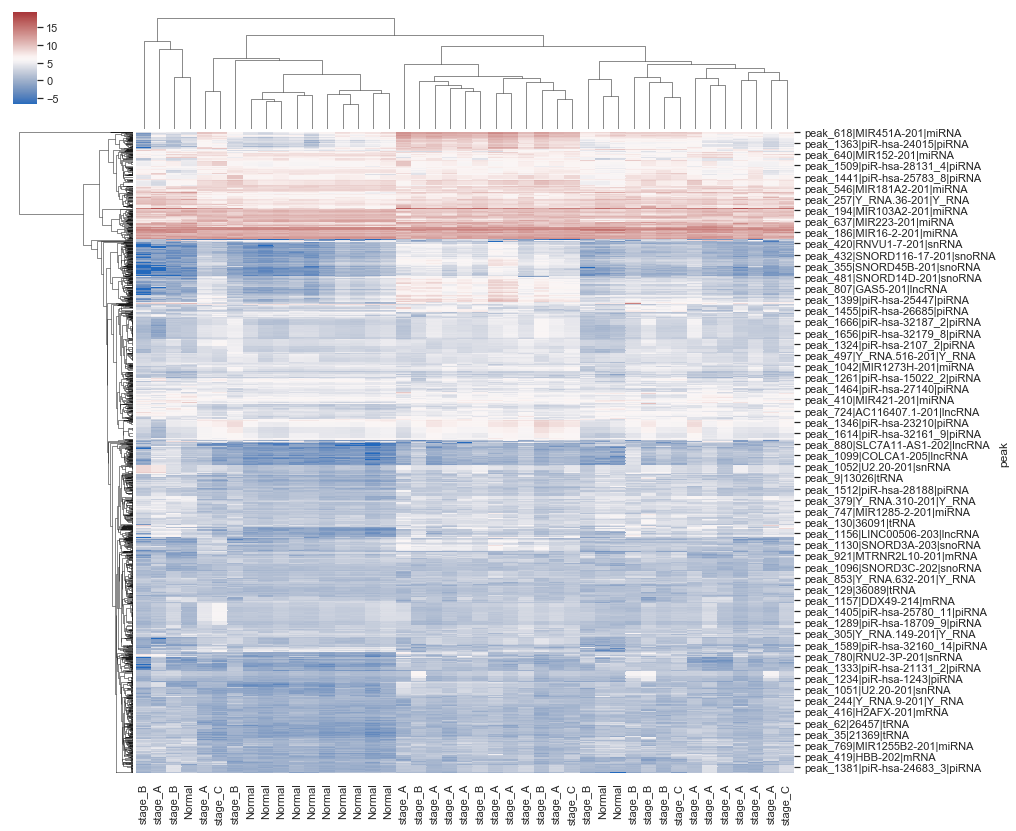

In [247]:
data = np.log2(cpm_filtered.iloc[np.argsort(-fano_coefs)[:2000]] + 0.01)
data.columns = sample_classes[data.columns.values].values
sns.clustermap(data, cmap='vlag', figsize=(14, 14), col_cluster=True)

In [18]:
cpm_median = cpm.median(axis=1)
cpm_median.head()

transcript
ENST00000473358.1|MIR1302-2HG-202|1544    0.0
ENST00000469289.1|MIR1302-2HG-201|843     0.0
ENST00000466430.5|AL627309.1-201|31638    0.0
ENST00000471248.1|AL627309.1-203|18221    0.0
ENST00000610542.1|AL627309.1-205|12999    0.0
dtype: float64

In [23]:
np.sum(nonzero_samples > cpm.shape[1]*0.2)

12343

In [ ]:
cv = GridSearchCV()

In [164]:
estimator = RandomForestClassifier()
cv = GridSearchCV(estimator, 
             param_grid={'n_estimators': [10, 25, 50, 75, 100],
                         'max_depth': list(range(2, 8))
                        },
            cv=3)
ranking = np.argsort(fano_coefs)[-5000:]
X = np.log10(cpm_filtered.iloc[ranking] + 0.01).T
features = cpm_filtered.index[ranking].values
labels = sample_classes[m.columns.values].values
X = X[np.isin(labels, ['Healthy Control', 'Colorectal Cancer'])]
y = (labels[np.isin(labels, ['Healthy Control', 'Colorectal Cancer'])] == 'Colorectal Cancer').astype(np.int32)
X = RobustScaler().fit_transform(X)
sample_weight = compute_sample_weight('balanced', y)
cv.fit(X, y, sample_weight=sample_weight)

estimator = cv.best_estimator_
estimator.fit(X, y, sample_weight=sample_weight)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 25, 50, 75, 100], 'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [171]:
estimator = cv.best_estimator_
rfe = RFE(estimator, 30, step=0.1)
rfe.fit(X, y)
#estimator.fit(X, y, sample_weight=sample_weight)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  n_features_to_select=30, step=0.1, verbose=0)

In [174]:
features[rfe.ranking_ == 1]

array(['ENST00000562691.2|AC010168.2-201|5428',
       'ENST00000471327.3|RN7SL825P-201|295',
       'ENST00000325658.3|PPM1A-202|39115',
       'ENST00000443617.6|HERC1-201|225271',
       'ENST00000379361.4|PTCHD1-201|70357',
       'ENST00000408749.1|RNU6ATAC-201|126', 'T315958|T315958|11249',
       'ENST00000225388.8|NUFIP2-201|38283',
       'ENST00000602755.1|AL356488.2-201|427',
       'ENST00000343110.2|PRELP-201|15525', 'T037600|T037600|4738',
       'ENST00000384000.1|SNORD116-9-201|95',
       'ENST00000284274.4|OTULIN-201|34964',
       'ENST00000602708.1|DENND4C-208|45875',
       'ENST00000364678.1|Y_RNA.266-201|96',
       'ENST00000475922.1|LPIN1-215|10361',
       'ENST00000362602.1|Y_RNA.36-201|112',
       'ENST00000384184.1|Y_RNA.447-201|113',
       'ENST00000602361.1|RMRP-201|268',
       'ENST00000362218.5|MIR379-201|67',
       'ENST00000464816.1|NEPRO-206|772',
       'ENST00000465963.1|TANC1-203|3238',
       'ENST00000385213.3|MIR328-201|75',
       'ENST000

In [166]:
np.sort(estimator.feature_importances_)[::-1]

array([0.01405193, 0.01093142, 0.00894744, ..., 0.        , 0.        ,
       0.        ])

In [167]:
features[np.argsort(-estimator.feature_importances_)][:100]

array(['T090280|T090280|18676', 'ENST00000364678.1|Y_RNA.266-201|96',
       '30130|30130|72', 'ENST00000602708.1|DENND4C-208|45875',
       'piR-hsa-30958_15|piR-hsa-30958_15|30',
       'ENST00000606837.1|MIR139-201|68',
       'piR-hsa-28116_6|piR-hsa-28116_6|32',
       'ENST00000595059.1|AC012313.8-201|5402',
       'ENST00000580243.1|TSHZ1-204|77113',
       'ENST00000602949.1|AC136475.7-201|592',
       'piR-hsa-23317|piR-hsa-23317|31',
       'ENST00000399151.3|DOPEY2-202|129740',
       'ENST00000410508.1|RNU2-26P-201|191',
       'ENST00000385273.1|MIR125A-201|86',
       'ENST00000365402.1|Y_RNA.347-201|101',
       'ENST00000325658.3|PPM1A-202|39115',
       'ENST00000362512.1|RNU12-201|150',
       'ENST00000263228.3|UBE2R2-201|102838',
       'ENST00000411069.1|RNU2-61P-201|191',
       'ENST00000432318.8_PAR_Y|CSF2RA-209|41095',
       'ENST00000629393.1|N4BP2L2-IT2-201|4890',
       'ENST00000363990.1|Y_RNA.196-201|109',
       'ENST00000637722.1|ARID1B-228|4235',
     

In [169]:
RFE?